In [30]:
# !pip install rdflib
# !pip install load_dotenv
# !pip install faiss-cpu
# !pip install --upgrade langchain-ollama
# !pip install --upgrade langchain 
# !pip install --upgrade langchain-community

In [31]:
import os
import re
import pickle
from pprint import pprint
from dotenv import load_dotenv
from rdflib import Graph

In [32]:
from langchain_core.documents import Document
from langchain_ollama import OllamaEmbeddings
from langchain.chat_models import ChatOllama
from langchain_core.messages import AIMessage

In [33]:
import faiss
from uuid import uuid4
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

In [34]:
# Configuration files
ttl_file = "/Users/Ruben/Github/MoMuHackathon/Data/new_data.ttl"
pkl_file = "/Users/Ruben/Github/MoMuHackathon/Data/dataset.pkl"
txt_for_validation = "/Users/Ruben/Github/MoMuHackathon/Data/new_data_graph_output.txt"
docs_path = "/Users/Ruben/Github/MoMuHackathon/output_documents"

In [35]:
def convert_ttl_to_dict(ttl_file, pkl_file, txt_for_validation):
    out = dict()
    g = Graph()
    g.parse(ttl_file, format="turtle")
    json_ld_data = g.serialize(format="json-ld", indent=4)
    with open(txt_for_validation, "w") as file:
        # Iterate through each triple in the graph
        subjects = set(g.subjects())
        for subject in subjects:
            org_subject = subject
            if "api/item" in subject:
                subj_formalized = str(subject).split('/')[-1]
                if '#' in subj_formalized:
                    subject = subj_formalized.split('#')[-1]
                else:
                    subject = subj_formalized
                out[subject] = {}
                file.write(f"Subject {subject}\n")
                # Iterate over all triples where this subject is the subject
                for pred, obj in g.predicate_objects(subject=org_subject):
                    pred_formalized = str(pred).split('/')[-1]
                    if '#' in pred_formalized:
                        pred = pred_formalized.split('#')[-1]
                    else:
                        pred = pred_formalized
                    if "http" not in obj:
                        out[subject][pred] = str(obj)
                        file.write(f"{pred}: {obj}\n")
                     
    with open(pkl_file, "wb") as f:
        pickle.dump(out, f)
    
    return out

In [36]:
dataset = convert_ttl_to_dict(ttl_file, pkl_file, txt_for_validation)
# with open(pkl_file, "rb") as f:
#     dataset = pickle.load(f)

In [37]:
def simplify_predicate(predicate):
    match = re.search(r"[#/](\w+)$", predicate)
    return match.group(1).replace("_", " ") if match else predicate

In [38]:
def generate_readable_content_v2(instance, properties):
    lines = []
    instance_id = str(instance).split("/")[-1]  
    # lines.append(f"The item {instance_id} has the following information:")
    
    for predicate, obj in properties:
        simplified_predicate = simplify_predicate(str(predicate))
        if "is_public" in str(predicate):
            lines.append(f"The item {instance_id} is {'public' if obj == 'true' else 'not public'}.")
        elif "title" in str(predicate):
            lines.append(f"The identifier of this artifact is \"{obj}\".")
        elif "description" in str(predicate):
            lines.append(f"The description of this artifact is \"{obj}\"")
        elif "date" == str(predicate):
            # print (predicate, obj)
            lines.append(f"This artifact was created from the following period: {obj}.")
        elif "modified" in str(predicate):
            lines.append(f"This artifact was last modified on {obj}.")
        elif "medium" in str(predicate):
            lines.append(f"The medium of this artifact includes {obj}.")
        elif "extent" in str(predicate):
            lines.append(f"The dimensions of this artifact are {obj}.")
        elif "publisher" in str(predicate):
            lines.append(f"The publisher of this artifact is {obj}.")
        elif "subject" in str(predicate):
            lines.append(f"The subject of this artifact includes {obj}.")
        elif "shortDescription" in str(predicate):
            obj = obj.replace('\n', '')
            lines.append(f"The context of this artifact is \"{obj}\".")
        elif "P48_has_preferred_identifier" in str(predicate):
            lines.append(f"The preferred identifier of this artifact is {obj}.")
        elif "P50_has_current_keeper" in str(predicate):
            lines.append(f"The current keeper of this artifact is {obj}.")
        elif "P55_has_current_location" in str(predicate):
            lines.append(f"The current location of this artifact is in {obj}.")
        elif "dateSubmitted" in str(predicate):
            lines.append(f"This artifact was submitted on {obj}.")
        elif "identifierGroupType" in str(predicate):
            lines.append(f"The group type of this artifact is  {obj}.")
        elif "identifierGroupValue" in str(predicate):
            lines.append(f"The group value of this artifact is {obj}.")
        elif simplified_predicate == "id":
            continue
        else:     
            # print (simplified_predicate)
            lines.append(f"The {simplified_predicate} of this artifact is {obj}.")
    
    return lines

In [39]:
def convert_pkl_to_doc(dataset, docs_path, save_txt = True):

    docs = list()
    combined_texts = dict()
    for item, val in dataset.items():
        item_id = str(item).split("/")[-1]
        properties = [(k, v) for k,v in val.items()]
        # lines = generate_readable_content(item, properties)
        lines = generate_readable_content_v2(item, properties)
        for line in lines:
            docs.append (
                Document(
                page_content = line,
                metadata={'item_id': item_id}
                )
        )

        combined_texts[item_id] = '\n'.join(lines)
        
        if save_txt:
            file_name = item_id + ".txt"  
            file_path = os.path.join(docs_path, file_name)
            with open(file_path, "w", encoding="utf-8") as f:
                f.write('\n'.join(lines))
                
    return docs, combined_texts

In [40]:
docs, combined_texts = convert_pkl_to_doc(dataset, docs_path)

In [41]:
# https://python.langchain.com/docs/integrations/vectorstores/faiss/

# embeddings = OllamaEmbeddings(model="llama3.2:1b")
embeddings = OllamaEmbeddings(model="mxbai-embed-large")

index = faiss.IndexFlatL2(len(embeddings.embed_query("hello world")))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

uuids = [str(uuid4()) for _ in range(len(docs))]
vector_store.add_documents(documents=docs, ids=uuids)

['b9e385af-9d2d-4407-b545-842a97559c70',
 '07d6b114-af87-4394-b8dc-7ce01aa74af4',
 '35464780-98b8-4973-97d3-54e7b8d7e0e6',
 'b784536c-189b-4622-b1b7-7090288c4c17',
 'd2327d75-194e-46e1-943f-d6ac8f5cdd0a',
 '7321354a-8782-4b14-aa73-4c455c0b77f7',
 'cf0e8588-5baf-4c6d-a226-7b5d43c8f2f9',
 'c0ede2a3-b969-47e9-a3d7-b5de6b981b54',
 'a0d267d9-f27e-4a2b-ae85-da9735af498f',
 'baa84b95-45a1-40da-8c83-301522ae87d2',
 'f0551430-1038-49e2-aee5-902a74e160f1',
 '45fd7796-f6d4-4bc2-834c-878df205d9e2',
 '9162f6a7-a384-4c81-b77f-c66e15d7295b',
 '70e56455-fc42-4ee1-a78d-9bbade46a97c',
 '9c212839-9b2d-4084-8bf9-eccede480c82',
 '712ea2ad-843f-4617-9a70-07eb4d74bae2',
 'f1019b9e-868b-42c9-8d22-82e97c083976',
 '1410e846-e3e1-45d0-b72a-3cbfbf049aa5',
 'c8ccecf9-481b-4138-aaf3-2e2bef5c74ee',
 '01cfc4ed-ca7f-4728-b5cd-ddc2ab1c6e40',
 '9cf3a45c-431a-4e81-a91a-7d6461b90c91',
 'b691cb9d-89c3-498d-8d08-fff181f17df7',
 '82676154-97b7-435f-9246-8165a671d326',
 '875de0fa-5c7e-46d2-9251-e105783e78e3',
 'cb9165be-2bd4-

In [48]:
# TEST DEMO: Similarity search
results = vector_store.similarity_search(
    "photography?",
    k=5,
    
)
for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

* The medium of this artifact includes voile. [{'item_id': '16034'}]
* The subject of this artifact includes ceintuur. [{'item_id': '14462'}]
* The medium of this artifact includes satijnbinding. [{'item_id': '15992'}]
* The medium of this artifact includes metaal. [{'item_id': '14641'}]
* The medium of this artifact includes metaal. [{'item_id': '14730'}]


In [43]:
def chat_llm(llm, query, new_m=None, messages=None):
    # results = vector_store.similarity_search(
    #     query,
    #     k=1,
    #     # filter={"source": "tweet"},
    # )
    # for res in results:
    #     print(f"* {res.page_content} [{res.metadata}]")
    
    # retrieve the right artifact 
    # simply pick the top one
    item_id = results[0].metadata['item_id']
    context = combined_texts[item_id]
    messages = [
        (
            "system",
            f"You are a helpful assistant in museum to explain the artifact. \
            You have the knowledge about the artifact: {context}. \
            Please answer the question \
            and then introduce detailed information about this artifact, \
            Your answer must include the identifier, created period, and 3-4 sentences as its description ",
        ),
        ("human", query),
    ]
    
    
    ai_msg = llm.invoke(messages)
    print('-'* 30 + " Context of the Artifact " + '-'* 30)
    print(context)
    print('-'* 30 + " LLM answer " + '-'* 30)
    print(ai_msg.content)
    return messages, results

In [57]:
# https://python.langchain.com/docs/integrations/chat/ollama/
llm = ChatOllama(model="llama3.2:1b", temperature=0)

In [58]:
query = "What can you tell me about the history of the artefact?"
chat_llm(llm, query)

------------------------------ Context of the Artifact ------------------------------
The created of this artifact is 2021-01-14T19:30:48+00:00.
The item 14455 is public.
This artifact was last modified on 2024-11-23T14:28:21+00:00.
The identifier of this artifact is "ST80185".
The creator of this artifact is OLYMPISCHE SPELEN LOS ANGELES.
This artifact was created from the following period: 1984.
The description of this artifact is "Oranje jas met vooraan twee zakken. De mouwen zijn onderaan afgewerkt met drie goudkleurige knopen. De jas sluit vooraan met twee goudkleurige knopen. Beige voering. De jas maakt deel uit van een uniform van de Olympische Zomerspelen in 1984."
The medium of this artifact includes polyester.
The publisher of this artifact is MOMU.
The subject of this artifact includes jas.
The context of this artifact is "De eerste moderne Olympische Spelen werden in de zomer van 1896 gehouden in Athene. In 1908 tijdens de Spelen in Londen werd voor het eerst een openingsde

([('system',
   'You are a helpful assistant in museum to explain the artifact.             You have the knowledge about the artifact: The created of this artifact is 2021-01-14T19:30:48+00:00.\nThe item 14455 is public.\nThis artifact was last modified on 2024-11-23T14:28:21+00:00.\nThe identifier of this artifact is "ST80185".\nThe creator of this artifact is OLYMPISCHE SPELEN LOS ANGELES.\nThis artifact was created from the following period: 1984.\nThe description of this artifact is "Oranje jas met vooraan twee zakken. De mouwen zijn onderaan afgewerkt met drie goudkleurige knopen. De jas sluit vooraan met twee goudkleurige knopen. Beige voering. De jas maakt deel uit van een uniform van de Olympische Zomerspelen in 1984."\nThe medium of this artifact includes polyester.\nThe publisher of this artifact is MOMU.\nThe subject of this artifact includes jas.\nThe context of this artifact is "De eerste moderne Olympische Spelen werden in de zomer van 1896 gehouden in Athene. In 1908 tij

In [ ]:
# TODO
# 1) improve the retrieval stage (acc & multi questions)
# 2) work on the system prompt to see what to display
# 3) backup the vector store 
# 4) reduce the inference time
# 5) introduce more metadata, e.g., image
# 6) multilingual feature

In [ ]:
import requests
from PIL import Image
import io
import json

BASE = "https://heron.libis.be/momu/api/items/"


def image_retriever(item_id):
    full_url = BASE + str(item_id)
    response = requests.get(full_url)

    # Convert JSON-LD to TTL

    data_dict = json.loads(response.content)
    
    image = Image.open(io.BytesIO(requests.get(data_dict["thumbnail_display_urls"]["large"]).content))
    return image

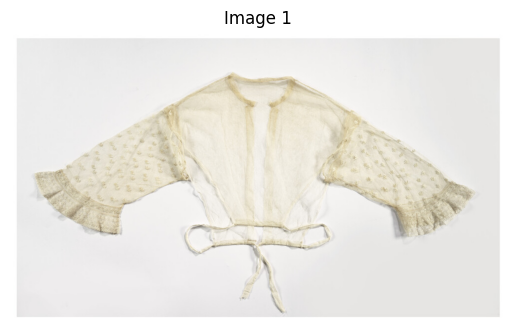

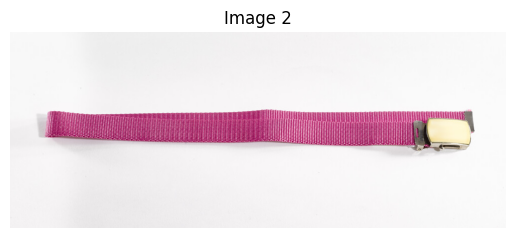

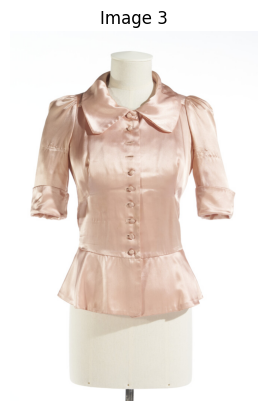

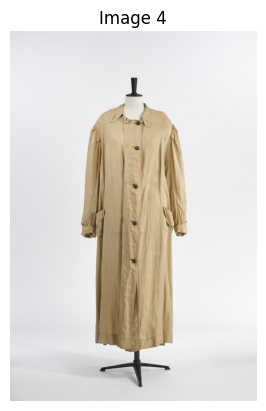

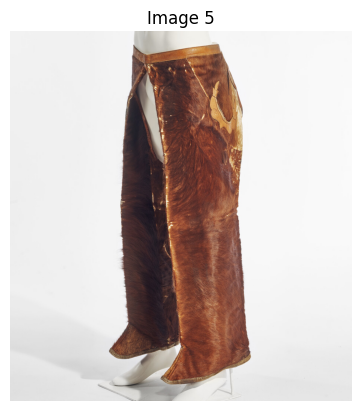

In [49]:
import matplotlib.pyplot as plt
images = [image_retriever(res.metadata['item_id']) for res in results]


for idx, img in enumerate(images):
    plt.figure()  # Create a new figure for each image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis for better visualization
    plt.title(f"Image {idx + 1}")
    plt.show()

* The context of this artifact is "De eerste moderne Olympische Spelen werden in de zomer van 1896 gehouden in Athene. In 1908 tijdens de Spelen in Londen werd voor het eerst een openingsdefilé ingevoerd. Vanaf de Spelen in 1924 in Parijs werd het gebruikelijk om tijdens deze ceremonie eenheid en spektakel uit te stralen door middel van een nationaal uniform. Geleidelijk in de jaren 1920 en 1930 krijgen ook stafleden zoals kaartverkopers, stadionportiers, gastvrouwen en gidsen een distinctief uniform. Zo was het stafuniform tijdens de Berlijnse Zomerspelen in 1936 wit.  In de jaren 1970 worden de uniformen in stijl en kleur uitgesplitst per functie om herkenbaarheid van verschillende functies te vergroten. Vanaf die tijd worden er ook internationaal bekende modeontwerpers en merken aangetrokken om de uniformen van het personeel in de stadions en de spelers van verschillende landen te ontwerpen. Voorbeelden hiervan zijn André Courrèges voor de Spelen in München in 1972, en Issey Miyake 

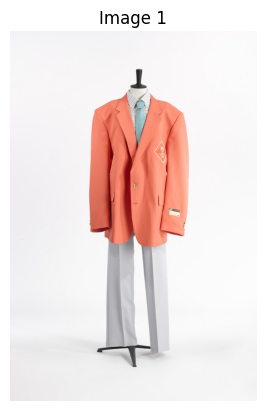

* The description of this artifact is "Wit T-shirt met ronde hals en korte mouwen. Over de schouders en tot de helft van de bovenkant van de mouwen loopt een oranjekleurige band. Onderaan de mouwen staat een rozekleurige band, boven de oranje afwerkingsboord. Het T-shirt maakt deel uit van een uniform van de staff van de Olympische Zomerspelen in 1984. Uniseks." [{'item_id': '14460'}]


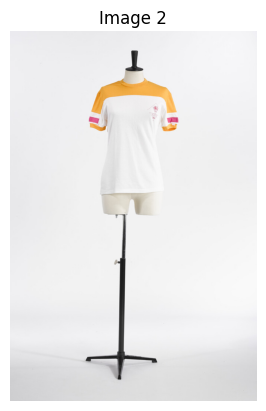

* The description of this artifact is "Paar schoenen in wit katoen met enkelband, vermoedelijk bestemd als wandel- en sportschoen." [{'item_id': '15631'}]


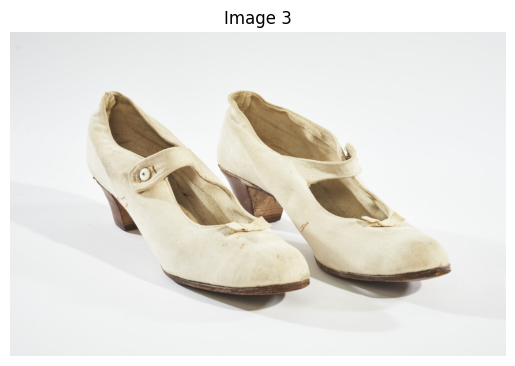

* The context of this artifact is "Professioneel cricketspeler William Lacey verhuist in 1887 vanuit Engeland naar Canada om daar te spelen en coachen. Aan het einde van dat decennium verhuist hij met zijn gezin naar Argentinië. In Buenos Aires zet Lacey zich in voor het in 1888 opgerichte Hurlingham Sports Club, een van de eerste sportclubs in Argentinië voor typisch Britse sporten als cricket, rugby en polo. Wanneer daar de vraag naar uitrustingen voor de sport polo toeneemt, begint hij met de verkoop van polosticks (zogenaamde ‘mallets’).  Later opent hij in het centrum van de stad een zaak voor (polo)sportkleding en materialen genaamd Lacey and Sons. Ook zoon Lewis Lacey, die internationaal bekend is als polospeler en zowel voor Engeland als Argentinië speelt, is betrokken bij zijn vaders zaak. Lewis ontwerpt in de jaren 1920 als eerste poloshirts met het logo van een polospeler te paard. Dit logo zal pas later in de jaren 1970 echt bekend gemaakt worden als het in aangepaste versi

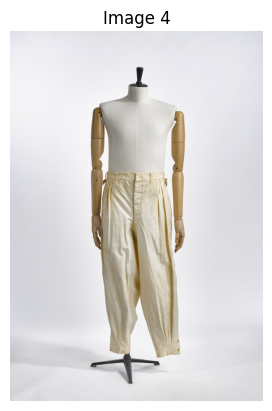

* The description of this artifact is "Roze riem met witte gesp. De riem maakt deel uit van een uniform van de Olympische Zomerspelen in 1984. Uniseks." [{'item_id': '14462'}]


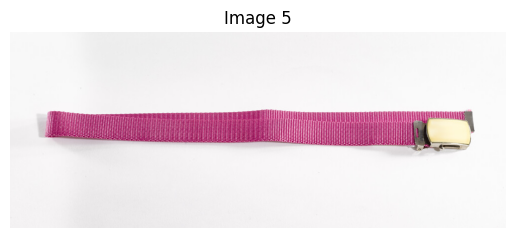

In [56]:
# TEST DEMO: Similarity search
results = vector_store.similarity_search(
    "sports",
    k=5,
    
)
for idx, res in enumerate(results):
    print(f"* {res.page_content} [{res.metadata}]")
    img = image_retriever(res.metadata['item_id'])
    plt.figure()  # Create a new figure for each image
    plt.imshow(img)
    plt.axis('off')  # Turn off axis for better visualization
    plt.title(f"Image {idx + 1}")
    plt.show()